In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm

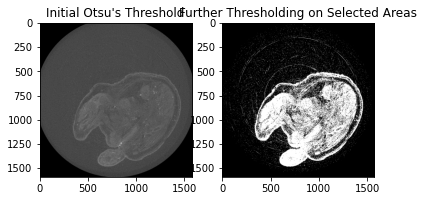

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('../datasets/test/Th24_PbRB-90kV-2-_rec00000352.tif', cv2.IMREAD_GRAYSCALE)

# Check if the image is loaded properly
if image is not None:
    # Apply Otsu's threshold
    _, binary_image_otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Mask for areas where binary_image_otsu is white
    mask = binary_image_otsu == 255

    # Extract the values in the image corresponding to the mask
    values_under_mask = image[mask]

    # Apply a secondary threshold, for example, another Otsu's but only on the masked areas
    _, secondary_thresholded_values = cv2.threshold(values_under_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Flatten the secondary thresholded values to make it a 1-dimensional array
    secondary_thresholded_values = secondary_thresholded_values.flatten()

    # Initialize a final thresholded image
    final_thresholded_image = np.zeros_like(image)
    
    # Place the secondary thresholded values back into the masked area in the final image
    final_thresholded_image[mask] = secondary_thresholded_values

    # Plot the original binary image from Otsu's threshold
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Initial Otsu\'s Threshold')

    # Plot the masked image ready for secondary thresholding
    plt.subplot(1, 2, 2)
    plt.imshow(final_thresholded_image, cmap='gray')  # Show the final thresholding on masked areas
    plt.title('Further Thresholding on Selected Areas')

In [37]:
def fill_largest_contour(image, binary_mask):
    # Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # If there are no contours, return the original image
    if not contours:
        return image
    # Find the largest contour based on area
    largest_contour = max(contours, key=cv2.contourArea)
    # Create a mask for the largest contour by drawing it filled on a new mask
    mask = np.zeros_like(binary_mask)


    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    return mask

def center_and_scale(img, mask):
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Find the largest contour which will be the main object
        c = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)  # Get bounding box of the largest contour
        
        # Crop the original image around this bounding box
        cropped_img = img[y:y+h, x:x+w]
        
        # Scale the cropped image back to the original size or desired size
        # Here, scaling back to original image size for simplicity
        scaled_img = cv2.resize(cropped_img, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_AREA)
        
        # Optionally, create a new blank image and place the scaled image in the center
        # This step is skipped here as we scale back to original size
        
        return scaled_img
    return img  # Return original if no contours found

In [105]:
def fill_large_contours(image, binary_mask, area_threshold):
    # Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # If there are no contours, return the original image
    if not contours:
        return image
    # Create a mask for all contours that are larger than the area threshold
    mask = np.zeros_like(binary_mask)
    for contour in contours:
        if cv2.contourArea(contour) > area_threshold:
            cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
    return mask

In [106]:
def center_and_scale(img, mask, desired_size=None):
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img  # Return original if no contours found

    # Calculate the combined bounding box around all contours
    min_x, min_y = img.shape[1], img.shape[0]
    max_x = max_y = 0
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        min_x, min_y = min(x, min_x), min(y, min_y)
        max_x, max_y = max(x+w, max_x), max(y+h, max_y)
    
    # Crop the original image around the combined bounding box
    cropped_img = img[min_y:max_y, min_x:max_x]

    # If desired_size is not specified, use the original image size
    if desired_size is None:
        desired_size = img.shape

    # Scale the cropped image to the desired size
    scaled_img = cv2.resize(cropped_img, desired_size[::-1], interpolation=cv2.INTER_AREA)

    # Create a new blank image and place the scaled image in the center
    final_img = np.zeros_like(img)
    x_offset = (final_img.shape[1] - scaled_img.shape[1]) // 2
    y_offset = (final_img.shape[0] - scaled_img.shape[0]) // 2
    final_img[y_offset:y_offset+scaled_img.shape[0], x_offset:x_offset+scaled_img.shape[1]] = scaled_img

    return final_img

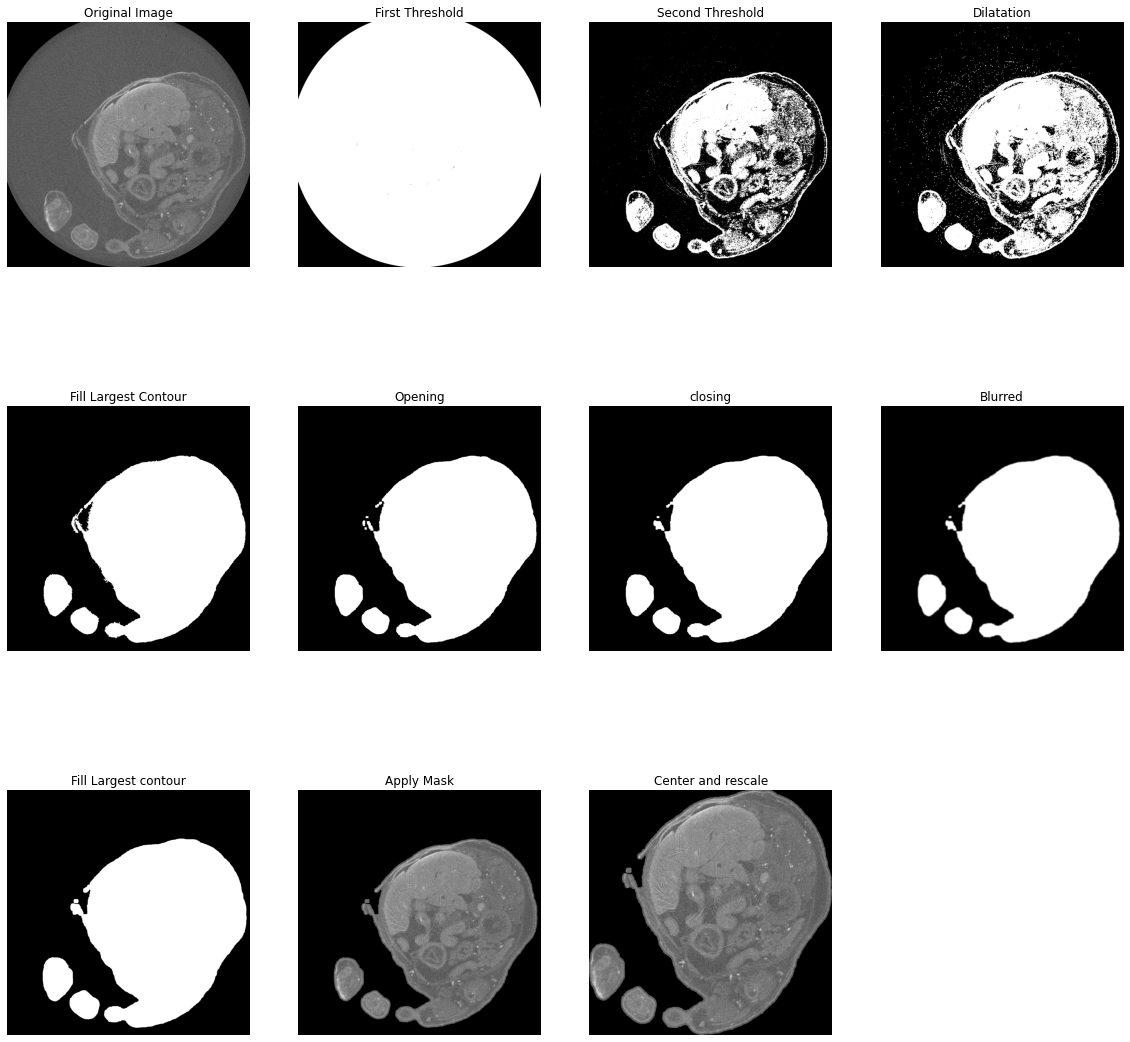

In [112]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('../datasets/test/Th24_PbRB-90kV-2-_rec00000352.tif', cv2.IMREAD_GRAYSCALE)
image = cv2.imread('../datasets/test/Th24_PbRB-90kV-2-_rec00000612.tif', cv2.IMREAD_GRAYSCALE)

# Check if the image is loaded properly
if image is not None:

    plt.figure(figsize=(20, 20))  # Set the figure size as desired

    # Step 1: Original Image
    plt.subplot(3, 4, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Apply Otsu's threshold
    _, binary_image_otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Step 2: First Threshold
    plt.subplot(3, 4, 2)
    plt.imshow(binary_image_otsu, cmap='gray')
    plt.title('First Threshold')
    plt.axis('off')

    # Mask for areas where binary_image_otsu is white
    mask = binary_image_otsu == 255

    # Extract the values in the image corresponding to the mask
    values_under_mask = image[mask]

    # Apply a secondary threshold, for example, another Otsu's but only on the masked areas
    _, secondary_thresholded_values = cv2.threshold(values_under_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Flatten the secondary thresholded values to make it a 1-dimensional array
    secondary_thresholded_values = secondary_thresholded_values.flatten()
    # Initialize a final thresholded image
    final_thresholded_image = np.zeros_like(image)
    # Place the secondary thresholded values back into the masked area in the final image
    final_thresholded_image[mask] = secondary_thresholded_values

    # Step 3: Second Threshold
    plt.subplot(3, 4, 3)
    plt.imshow(final_thresholded_image, cmap='gray')
    plt.title('Second Threshold')
    plt.axis('off')

    # Use dilation to make the regions within the threshold bigger
    kernel = np.ones((3,3), np.uint8)
    #binary_image_otsu = cv2.morphologyEx(final_thresholded_image, cv2.MORPH_OPEN, kernel, iterations=2)
    binary_image_otsu = cv2.dilate(final_thresholded_image, kernel, iterations=1)

    # Step 4: Dilatation
    plt.subplot(3, 4, 4)
    plt.imshow(binary_image_otsu, cmap='gray')
    plt.title('Dilatation')
    plt.axis('off')

    contour_mask = fill_large_contours(image,binary_image_otsu, 500)

    # Step 5: Fill Largest Contour
    plt.subplot(3, 4, 5)
    plt.imshow(contour_mask, cmap='gray')
    plt.title('Fill Largest Contour')
    plt.axis('off')

    # Apply morphological opening to remove small artifacts
    kernel = np.ones((7, 7), np.uint8)
    opening = cv2.morphologyEx(contour_mask, cv2.MORPH_OPEN, kernel, iterations=2)

        # Step 6: Opening
    plt.subplot(3, 4, 6)
    plt.imshow(opening, cmap='gray')
    plt.title('Opening')
    plt.axis('off')

    # Apply morphological closing to smooth the outside
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=3)

        # Step 7: Closing
    plt.subplot(3, 4, 7)
    plt.imshow(closing, cmap='gray')
    plt.title('closing')
    plt.axis('off')

    # Apply Gaussian blurring to the closing image
    blurred = cv2.GaussianBlur(closing, (15, 15), 0)

        # Step 8: Blurred
    plt.subplot(3, 4, 8)
    plt.imshow(blurred, cmap='gray')
    plt.title('Blurred')
    plt.axis('off')


    new_contour_mask = fill_large_contours(image, blurred, 500)

            # Step 9: Fill Largest contour
    plt.subplot(3, 4, 9)
    plt.imshow(new_contour_mask, cmap='gray')
    plt.title('Fill Largest contour')
    plt.axis('off')


    result_img = cv2.bitwise_and(image, image, mask=new_contour_mask)

                # Step 10: Fill Largest contour
    plt.subplot(3, 4, 10)
    plt.imshow(result_img, cmap='gray')
    plt.title('Apply Mask')
    plt.axis('off')

    result_img = center_and_scale(result_img, new_contour_mask)

                    # Step 11: Center and rescale
    plt.subplot(3, 4, 11)
    plt.imshow(result_img, cmap='gray')
    plt.title('Center and rescale')
    plt.axis('off')


else:
    print("Failed to load the image.")
